/home/daniil/repos/anaconda2/lib/python2.7/site-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)
/home/daniil/repos/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")
/home/daniil/repos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


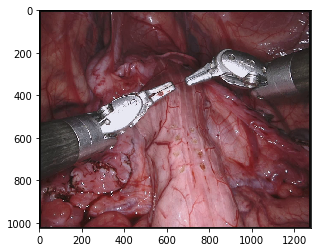

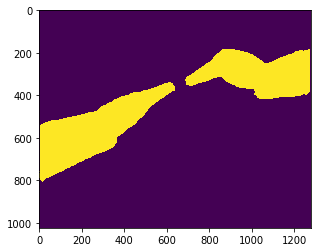

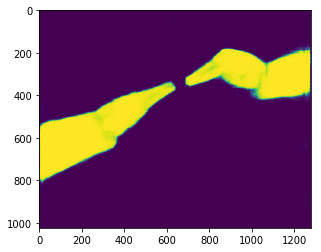

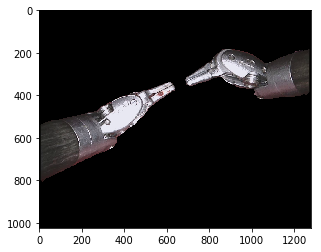

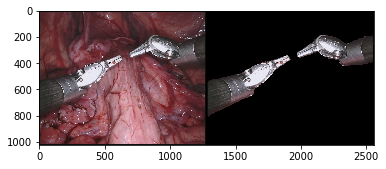

In [1]:
import sys, os
sys.path.append("/home/daniil/repos/pytorch-segmentation-detection/")
sys.path.insert(0, '/home/daniil/repos/pytorch-segmentation-detection/vision/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from PIL import Image
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
from torch.autograd import Variable
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated
from pytorch_segmentation_detection.datasets.endovis_instrument_2017 import get_sorted_by_name_image_names

import numpy as np


images_folder = '/home/daniil/projects/endovis/dataset/instrument_dataset_3/left_frames/'

frames_filenames = get_sorted_by_name_image_names(images_folder)

valid_transform = transforms.Compose(
                [
                     transforms.CenterCrop((1024, 1280)),
                     transforms.ToTensor(),
                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                ])

just_crop_transform = transforms.CenterCrop((1024, 1280))

fcn = resnet_dilated.Resnet18_8s(num_classes=2)
fcn.load_state_dict(torch.load('resnet_18_8s_best.pth'))
fcn.cuda()
fcn.eval()

img_path = frames_filenames[0]

current_image = Image.open(img_path)


#img_not_preprocessed = Image.fromarray(current_image).convert('RGB')
img_not_preprocessed = current_image.convert('RGB')

current_img_crop = np.asarray(just_crop_transform(img_not_preprocessed))

img = valid_transform(img_not_preprocessed)

img = img.unsqueeze(0)

img = Variable(img.cuda())

res = fcn(img)

soft_labels = torch.nn.functional.softmax(res).squeeze(0)

_, hard_labels = res.squeeze(0).max(0)

segmentation = hard_labels.data.cpu().numpy().squeeze()
soft_mask = soft_labels.data.cpu().numpy()[1, :, :]

hard_masked_out_instrument = current_img_crop * np.expand_dims(segmentation, 2).astype(np.uint8)

soft_masked_out_instrument = (((current_img_crop.astype(np.float32) / 255) * np.expand_dims(soft_mask, 2)) * 255).astype(np.uint8)

double_view = np.zeros((1024, 1280*2, 3), np.uint8)

double_view[:1024, :1280, :] = current_img_crop
double_view[:1024, 1280:, :] = hard_masked_out_instrument


plt.imshow(current_img_crop)
plt.show()

plt.imshow(segmentation)
plt.show()

plt.imshow(soft_mask)
plt.show()

plt.imshow(hard_masked_out_instrument)
plt.show()

plt.imshow(double_view)
plt.show()

In [2]:
save_file_template = 'output_frames/{0:08d}.png'

for index, frame_filename in enumerate(frames_filenames):

    current_image = Image.open(frame_filename)
    
    img_not_preprocessed = current_image.convert('RGB')

    current_img_crop = np.asarray(just_crop_transform(img_not_preprocessed))

    img = valid_transform(img_not_preprocessed)

    img = img.unsqueeze(0)

    img = Variable(img.cuda())

    res = fcn(img)

    soft_labels = torch.nn.functional.softmax(res).squeeze(0)

    _, hard_labels = res.squeeze(0).max(0)

    segmentation = hard_labels.data.cpu().numpy().squeeze()
    soft_mask = soft_labels.data.cpu().numpy()[1, :, :]

    hard_masked_out_instrument = current_img_crop * np.expand_dims(segmentation, 2).astype(np.uint8)

    soft_masked_out_instrument = (((current_img_crop.astype(np.float32) / 255) * np.expand_dims(soft_mask, 2)) * 255).astype(np.uint8)

    double_view = np.zeros((1024, 1280*2, 3), np.uint8)

    double_view[:1024, :1280, :] = current_img_crop
    double_view[:1024, 1280:, :] = hard_masked_out_instrument

    image_filename_to_save = save_file_template.format(index)
    
    plt.imsave(image_filename_to_save, double_view)
    
    print(image_filename_to_save)

/home/daniil/repos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


output_frames/00000000.png
output_frames/00000001.png
output_frames/00000002.png
output_frames/00000003.png
output_frames/00000004.png
output_frames/00000005.png
output_frames/00000006.png
output_frames/00000007.png
output_frames/00000008.png
output_frames/00000009.png
output_frames/00000010.png
output_frames/00000011.png
output_frames/00000012.png
output_frames/00000013.png
output_frames/00000014.png
output_frames/00000015.png
output_frames/00000016.png
output_frames/00000017.png
output_frames/00000018.png
output_frames/00000019.png
output_frames/00000020.png
output_frames/00000021.png
output_frames/00000022.png
output_frames/00000023.png
output_frames/00000024.png
output_frames/00000025.png
output_frames/00000026.png
output_frames/00000027.png
output_frames/00000028.png
output_frames/00000029.png
output_frames/00000030.png
output_frames/00000031.png
output_frames/00000032.png
output_frames/00000033.png
output_frames/00000034.png
output_frames/00000035.png
output_frames/00000036.png
o

In [12]:
import imageio
import skimage.io as io

fps = 2

writer = imageio.get_writer('validation_final.mp4', fps=fps)

for index in xrange(len(frames_filenames)):
    
    image_filename_to_read = save_file_template.format(index)

    img = io.imread(image_filename_to_read)
    
    writer.append_data(img)

writer.close()